# IMPORTS

## Libraries

In [1]:
import pandas as pd
import numpy as np
import random
import datetime
import pickle

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import HTML

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso

import xgboost as xgb
from lightgbm import LGBMRegressor

## Helper Functions

In [2]:
def crossValidation(XTraining, kfold, modelName, model='default', verbose=False):
    maeList = []
    mapeList = []
    rmseList = []

    for k in reversed(range(1, kfold+1)):
        if verbose:
            print(f'\nKFold Number: {k}')
        # Start and End Date for Validation
        startDateValid = XTraining['Date'].max() - datetime.timedelta(days=k*6*7)
        endDateValid = XTraining['Date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # Filtering Dataset
        training = XTraining[XTraining['Date'] < startDateValid]
        validation = XTraining[(XTraining['Date'] >= startDateValid) & (XTraining['Date'] <= endDateValid)]

        # Training and Validation Dataset
        # Training
        XKFoldTraining = training.drop(['Date', 'Sales'], axis=1)
        yKFoldTraining = training['Sales']

        # Validation
        XKFoldValidation = validation.drop(['Date', 'Sales'], axis=1)
        yKFoldValidation = validation['Sales']

        # Model
        ## Model Map
        modelMap = {
            'Linear Regression': LinearRegression(),
            'Lasso': Lasso(alpha=0.01),
            'Random Forest Regressor': RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42),
            'XGBoost Regressor': xgb.XGBRegressor( objective='reg:squarederror', n_estimators=500, eta=0.01, max_depth=10, 
                                                      subsample=0.7, colsample_bytree=0.9),
            'Lightgbm Regressor': LGBMRegressor(num_leaves=10, min_data_in_leaf=50, n_jobs=-1, random_state=42, n_estimators=500)   
        }
        
        ## Mapped Model
        if model == 'default':
            model = modelMap[modelName]
        else: model = model
        
        model.fit(XKFoldTraining, yKFoldTraining)

        # Prediction
        yhat = model.predict(XKFoldValidation)

        #Performance
        modelResult = mlError('Linear Regression', np.expm1(yKFoldValidation), np.expm1(yhat))
        
        #Store Performance of each KFold iteration
        maeList.append(modelResult['MAE'].tolist())
        mapeList.append(modelResult['MAPE'].tolist())
        rmseList.append(modelResult['RMSE'].tolist())


    dictResult = {
                    'Model Name': [modelName],
                    'MAE CV': [np.round(np.mean(maeList),2).astype(str) + ' +/- ' + np.round(np.std(maeList),2).astype(str)],
                    'MAPE CV': [np.round(np.mean(mapeList),2).astype(str) + ' +/- ' + np.round(np.std(mapeList),2).astype(str)],
                    'RMSE CV': [np.round(np.mean(rmseList),2).astype(str) + ' +/- ' + np.round(np.std(rmseList),2).astype(str)]
                }

    return pd.DataFrame(dictResult)


def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))


def mlError(modelName, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({
                            'ModelName': modelName,
                            'MAE': mae,
                            'MAPE': mape,
                            'RMSE': rmse,
                        }, index=[0])



def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 16]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## Loading Data

In [4]:
dfRaw = pd.read_csv('../../01-Data/Results/01-FirstRoundCRISP/dfFinalModel.csv', low_memory=False, parse_dates=['Date'])

# TRANSLATION AND INTERPRETATION OF THE ERROR

In [5]:
dfRaw1 = dfRaw.copy()

## Business Performance

In [9]:
# sum of predictions
dfFinal1 = dfRaw1[['Store', 'Predictions']].groupby( 'Store' ).sum().reset_index()

# MAE and MAPE
dfFinalAux1 = dfRaw1[['Store', 'Sales', 'Predictions']].groupby('Store').apply( lambda x: mean_absolute_error(x['Sales'], x['Predictions'])).reset_index().rename(columns={0:'MAE'})
dfFinalAux2 = dfRaw1[['Store', 'Sales', 'Predictions']].groupby('Store').apply( lambda x: mean_absolute_percentage_error(x['Sales'], x['Predictions'])).reset_index().rename(columns={0:'MAPE'})

# Merge
dfFinalAux3 = pd.merge(dfFinalAux1, dfFinalAux2, how='inner', on='Store')
dfFinal2 = pd.merge(dfFinal1, dfFinalAux3, how='inner', on='Store')

# Scenarios
dfFinal2['WorstScenario'] = dfFinal2['Predictions'] - dfFinal2['MAE']
dfFinal2['BestScenario'] = dfFinal2['Predictions'] + dfFinal2['MAE']

# order columns
dfFinal2 = dfFinal2[['Store', 'Predictions', 'WorstScenario', 'BestScenario', 'MAE', 'MAPE']]

In [10]:
dfFinal2.sort_values('MAPE', ascending=False).head()

,Store,Predictions,WorstScenario,BestScenario,MAE,MAPE
291,292,108198.5386,104784.733158,111612.344042,3413.805442,0.595464
908,909,223889.9750,216045.037739,231734.912261,7844.937261,0.518731
285,286,174648.6491,173616.172097,175681.126103,1032.477003,0.369776
594,595,347355.8119,342440.752762,352270.871038,4915.059138,0.338724
901,902,194486.8729,193227.984443,195745.761357,1258.888457,0.316353


In [11]:
dfFinal2.sort_values('MAPE', ascending=True).head()

,Store,Predictions,WorstScenario,BestScenario,MAE,MAPE
1088,1089,376102.3513,375588.564881,376616.137719,513.786419,0.047016
258,259,540342.6855,539714.197791,540971.173209,628.487709,0.049373
357,358,359283.4585,358760.667881,359806.249119,522.790619,0.053267
741,742,296244.0165,295800.136032,296687.896968,443.880468,0.053436
561,562,726751.0530,725819.920326,727682.185674,931.132674,0.054465


In [12]:
mpe = mean_percentage_error(dfRaw1['Sales'], dfRaw1['Predictions'])
mpe

-0.010042327927746555

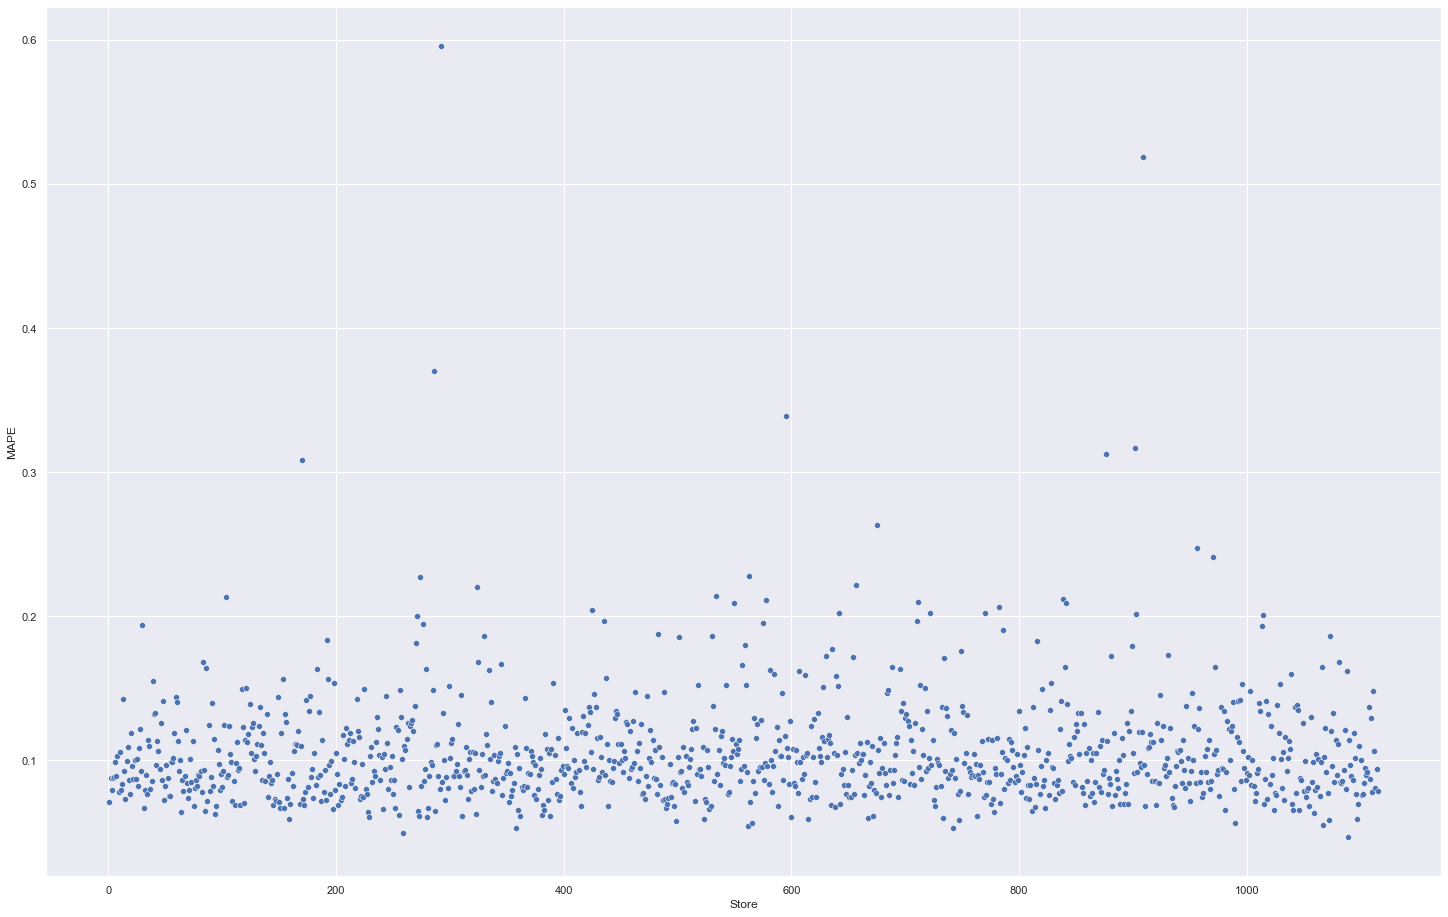

In [14]:
sns.scatterplot( x='Store', y='MAPE', data=dfFinal2 )
plt.show()

## Total Performance

In [15]:
dfFinal3 = dfFinal2[['Predictions', 'WorstScenario', 'BestScenario']].apply(lambda row: np.sum(row), axis=0).reset_index().rename(columns={'index': 'Scenario', 0:'Values'})
dfFinal3['Values'] = dfFinal3['Values'].map( 'R${:,.2f}'.format )
dfFinal3

,Scenario,Values
0,Predictions,"R$284,598,424.80"
1,WorstScenario,"R$283,805,765.03"
2,BestScenario,"R$285,391,084.57"


## Machine Learning Performance

In [16]:
dfRaw1['Error'] = dfRaw1['Sales'] - dfRaw1['Predictions']
dfRaw1['ErrorRate'] = dfRaw1['Predictions'] / dfRaw1['Sales']

<AxesSubplot:xlabel='Predictions', ylabel='Error'>

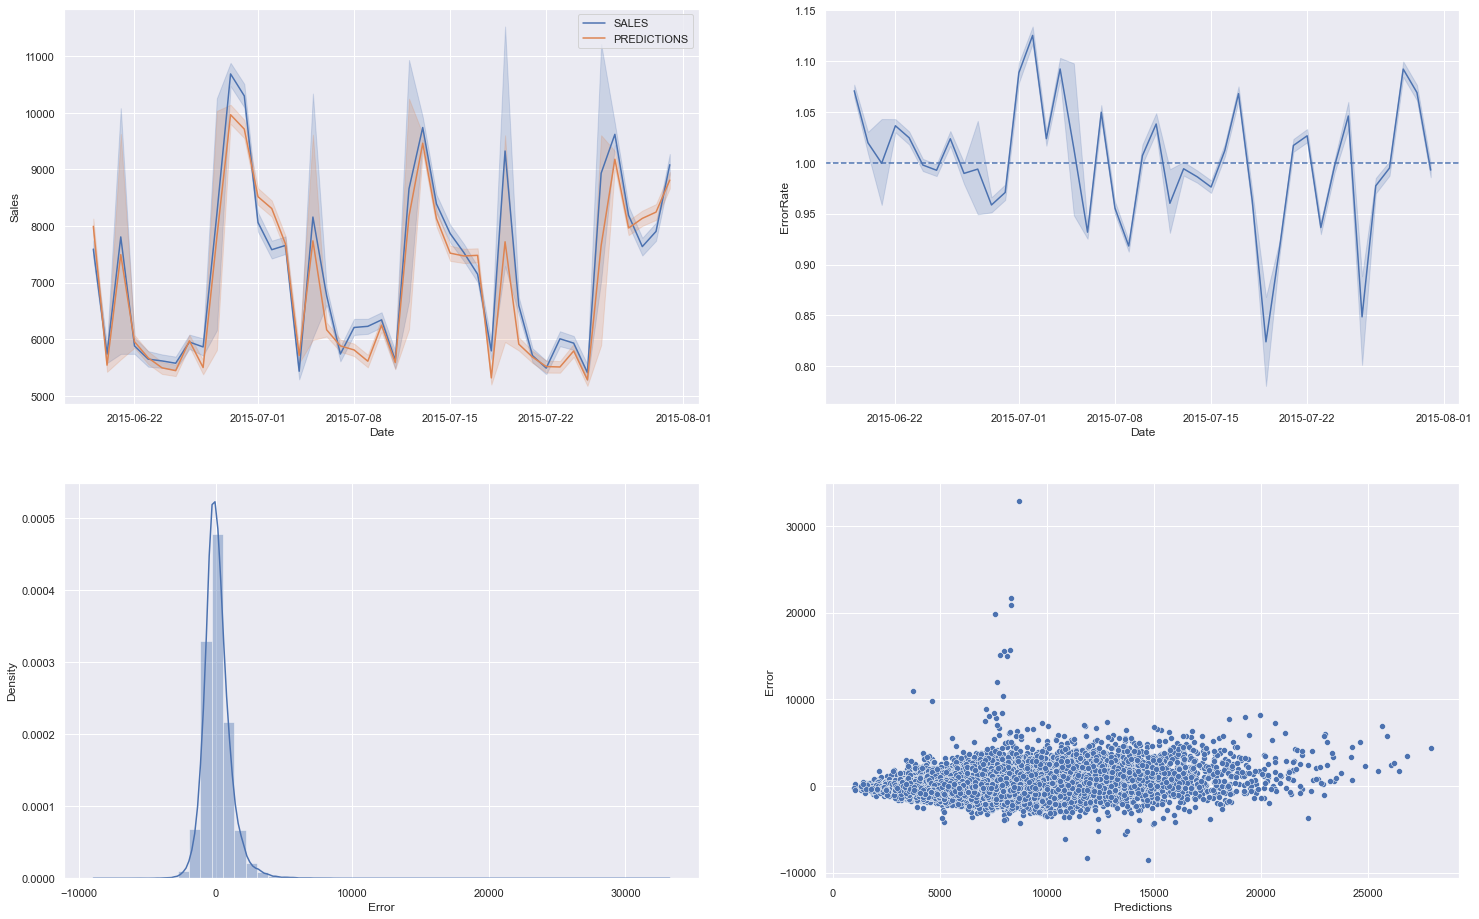

In [17]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='Date', y='Sales', data=dfRaw1, label='SALES' )
sns.lineplot( x='Date', y='Predictions', data=dfRaw1, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='Date', y='ErrorRate', data=dfRaw1 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( dfRaw1['Error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( dfRaw1['Predictions'], dfRaw1['Error'] )